In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, auroc, f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

/home/susan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/susan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/susan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/susan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: Futu

42

In [7]:
products_df = pd.read_csv("data/products.csv")
# df = pd.read_csv("../../lightning-template/pytorch-lightning-projects-pipeline/data/goods_categorization/raw_data/products.csv")
train_df, test_df = train_test_split(products_df, test_size=0.2)

In [8]:
train_df.head()

,row_number,product_title,category_id
14796,14797,Стекло защитное Honor 20/ Honor 20 PRO/ Huawei...,13408
87504,87505,"Крем для лица BIHADO, Многофункциональный гель...",2634
34023,34024,Гель-лак 25 дней 66 - Мятный десерт POSH SE...,13995
27176,27177,Защитный силиконовый матовый чехол для iphone ...,11937
113960,113961,Автомобильный держатель для телефона с беспров...,14241


In [10]:
print(len(train_df.index))
print(train_df.category_id.nunique())

115265
779


<AxesSubplot:xlabel='category_id', ylabel='Count'>

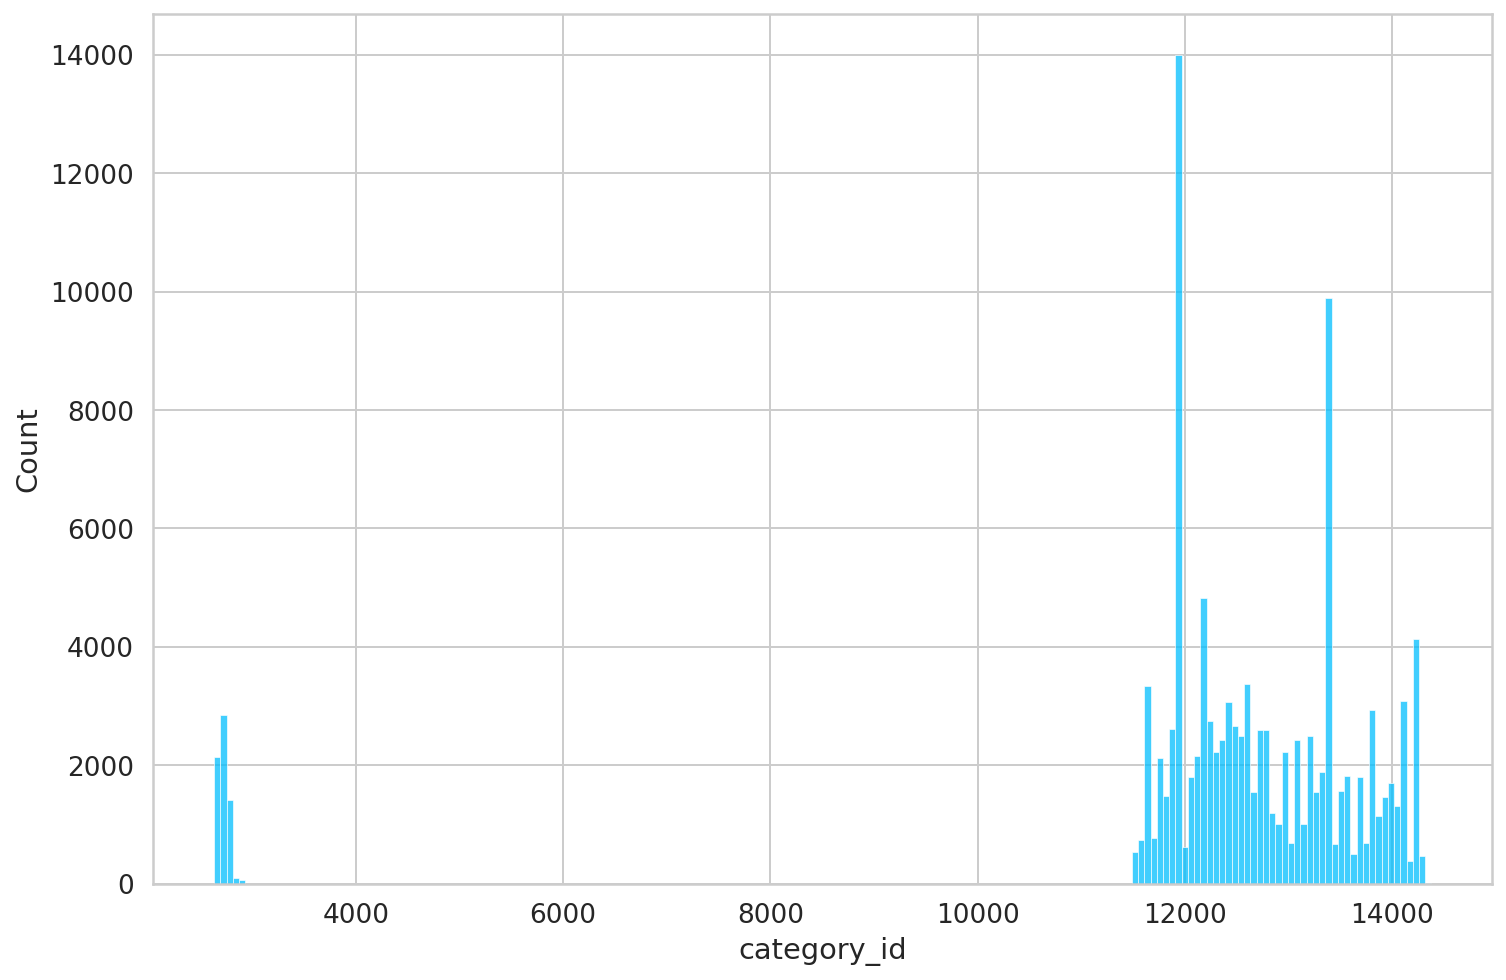

In [11]:
sns.histplot(train_df.category_id)

<AxesSubplot:xlabel='category_id', ylabel='Count'>

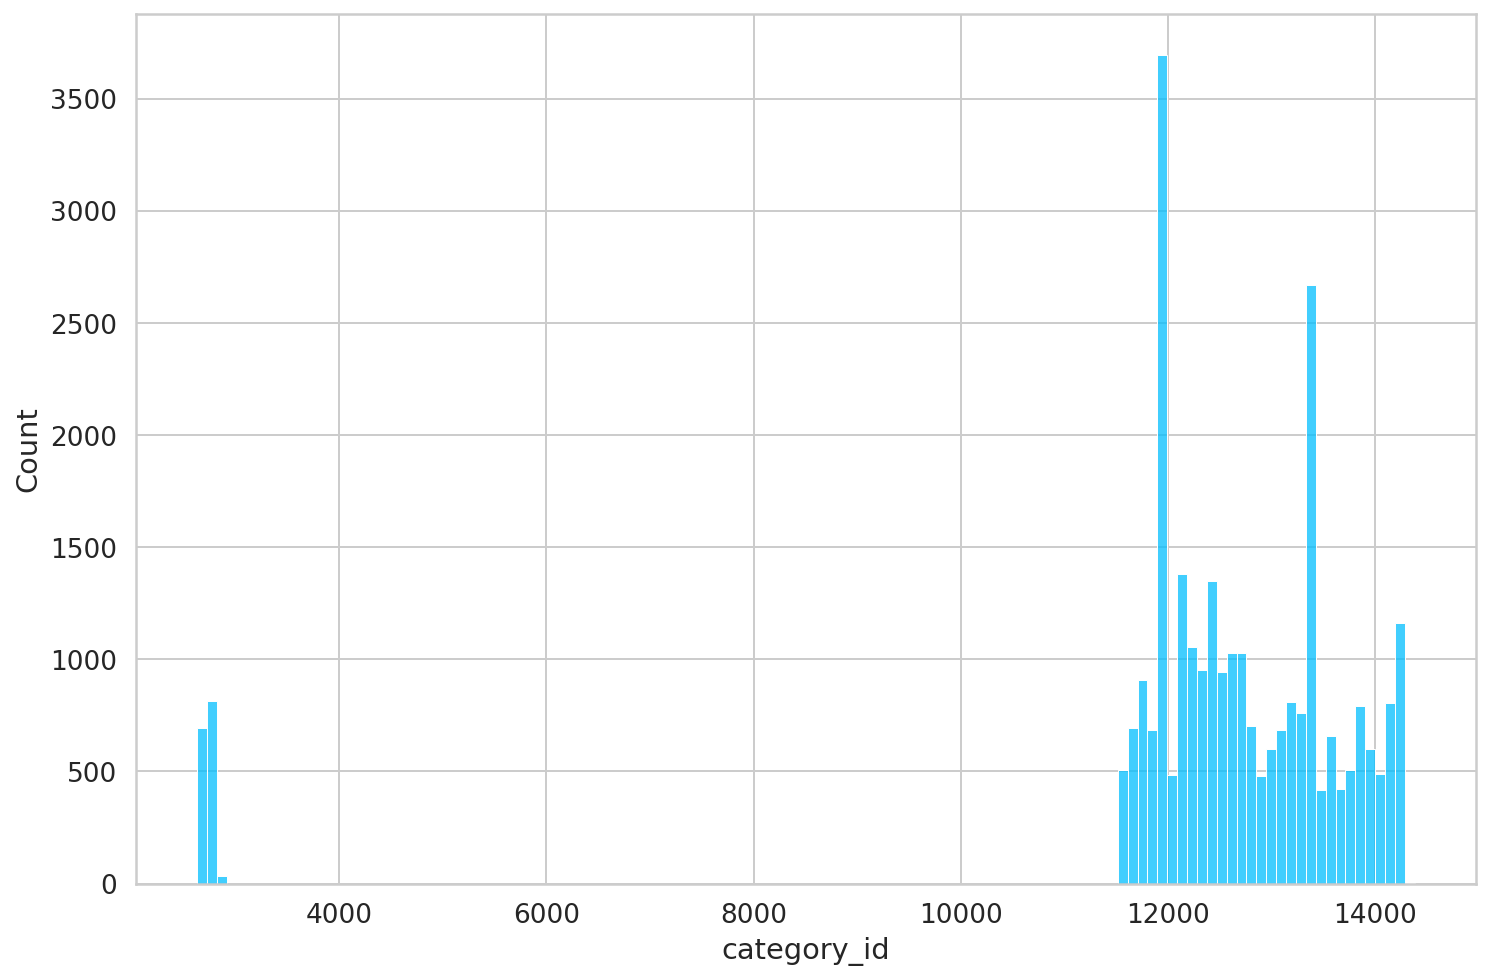

In [12]:
sns.histplot(test_df.category_id)

In [23]:
print(train_df.category_id.count)

<bound method Series.count of 14796     13408
87504      2634
34023     13995
27176     11937
113960    14241
          ...  
110268    12669
119879    13408
103694    13203
131932    12604
121958    11937
Name: category_id, Length: 115265, dtype: int64>


In [3]:
categories_df = pd.read_csv("data/categories.csv")
categories_df.head()

,category_id,category_title,category_path
0,13021,Базы и топы,1.10012.10113.13021
1,2740,Полки и подставки,1.10018.10110.12842.2740
2,13182,Салюты,1.10018.10118.10749.13182
3,2864,Ложки для обуви,1.10018.10110.12823.2864
4,14154,Аромабудильники и картриджи,1.10020.10227.14154


In [5]:
print(len(categories_df.index))
print(categories_df.category_id.nunique())

959
959


In [11]:
# predicted_labels = [12407, 1, 1]
predicted_labels = [13254, 1, 1]
categories_df[categories_df.category_id == predicted_labels[0]]

,category_id,category_title,category_path
179,13254,Принадлежности для мытья посуды,1.10018.10115.10390.13254


In [12]:
categories_df[categories_df.category_id == predicted_labels[0]]["category_title"].iloc[0]

'Принадлежности для мытья посуды'